<a href="https://colab.research.google.com/github/RachidaMellouli/Projects/blob/main/prediction_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
y_train_test = []
init_notebook_mode(connected=True) ## plotly init
seed = 123
random.seed = seed

In [ ]:
filenames_list_benign = os.listdir('./drive/MyDrive/data/benign/') ## list of file names in the directory
filenames_list_malignant = os.listdir('./drive/MyDrive/data/malignant/') 
dataSet = [] ## create an empty df that will hold data from each file
y_train_test = []

In [ ]:
for file_name in tqdm(filenames_list_benign):
    temp_df = cv2.imread('./drive/MyDrive/data/benign/' + file_name) ## read from the file to df
    dataSet.append(temp_df) ## add the file data to the main df
    y_train_test.append([1,0])

100%|██████████| 1800/1800 [00:08<00:00, 213.51it/s]


In [ ]:
for file_name in tqdm(filenames_list_malignant):
    temp_df = cv2.imread('./drive/MyDrive/data/malignant/' + file_name) ## read from the file to df
    dataSet.append(temp_df) ## add the file data to the main df
    y_train_test.append([0,1]) 

100%|██████████| 1497/1497 [00:05<00:00, 263.02it/s]


In [ ]:
print(y_train_test)

[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0],

In [ ]:
y_train_test = np.array(y_train_test)
dataSet = np.array(dataSet)

In [ ]:
print(y_train_test.shape)
print(dataSet.shape)

(3297, 2)
(3297, 224, 224, 3)


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test  = train_test_split(dataSet, y_train_test, test_size=0.20, random_state=42)

NameError: ignored

In [ ]:
print(x_train.shape)
print(x_test.shape)

(2967, 224, 224, 3)
(330, 224, 224, 3)


In [ ]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from tensorflow.keras.optimizers import Adam



def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)

    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters


def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters


def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(224, 224, 3))
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)

In [ ]:
dense_block_size = 3
layers_in_block = 4

growth_rate = 12
classes = 2
model_Dense = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model_Dense.summary()


# training
batch_size = 32
epochs = 23
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_Dense.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])
hist2=model_Dense.fit(x_train,y_train, epochs=epochs, batch_size=batch_size, shuffle=True,validation_data=(x_test, y_test))

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_60 (Conv2D)             (None, 224, 224, 24  648         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 activation_64 (Activation)     (None, 224, 224, 24  0           ['conv2d_60[0][0]']              
                                )                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



93/93 [==============================] - 946s 10s/step - loss: 0.5106 - accuracy: 0.7344 - val_loss: 0.5855 - val_accuracy: 0.7212
Epoch 2/15
93/93 [==============================] - 893s 10s/step - loss: 0.4236 - accuracy: 0.7900 - val_loss: 0.4363 - val_accuracy: 0.7697
Epoch 3/15
93/93 [==============================] - 891s 10s/step - loss: 0.4098 - accuracy: 0.7893 - val_loss: 0.4261 - val_accuracy: 0.7848
Epoch 4/15
93/93 [==============================] - 892s 10s/step - loss: 0.4077 - accuracy: 0.7988 - val_loss: 0.4008 - val_accuracy: 0.7939
Epoch 5/15
93/93 [==============================] - 900s 10s/step - loss: 0.3946 - accuracy: 0.8045 - val_loss: 0.3670 - val_accuracy: 0.8212
Epoch 6/15
93/93 [==============================] - 961s 10s/step - loss: 0.3875 - accuracy: 0.8005 - val_loss: 0.3696 - val_accuracy: 0.8303
Epoch 7/15
93/93 [==============================] - 970s 10s/step - loss: 0.3832 - accuracy: 0.8106 - val_loss: 0.3561 - val_accuracy: 0.8485
Epoch 8/15
93/93 

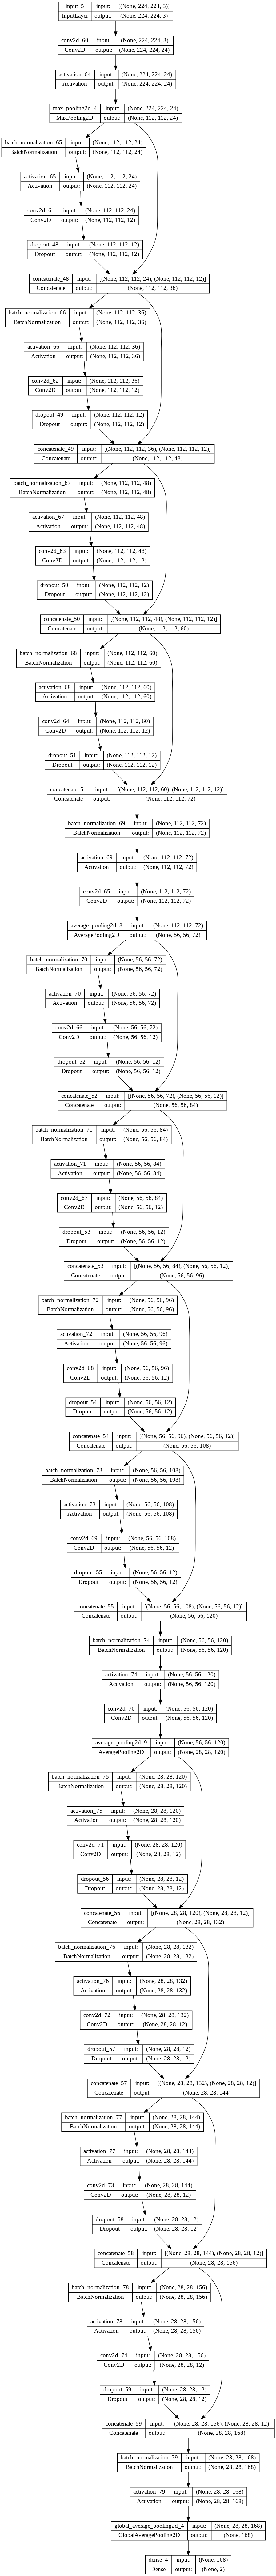

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_Dense, to_file='model_Dense.png', show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [ ]:
ypred = model_Dense.predict(x_test)
print("DenseNet Model")

print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(ypred, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(ypred, axis=1)))


11/11 [==============================] - 19s 2s/step
DenseNet Model
[[166  27]
 [ 23 114]]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       193
           1       0.81      0.83      0.82       137

    accuracy                           0.85       330
   macro avg       0.84      0.85      0.84       330
weighted avg       0.85      0.85      0.85       330



DenseNet Model


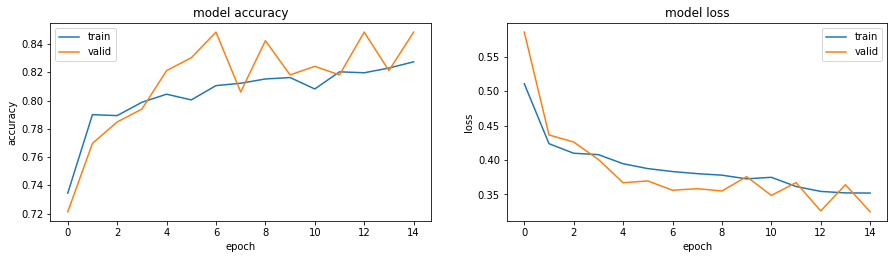

In [ ]:
print("DenseNet Model") 
plt.figure(1, figsize = (15,8)) 
   
plt.subplot(221)  
plt.plot(hist2.history['accuracy'])  
plt.plot(hist2.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(hist2.history['loss'])  
plt.plot(hist2.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
model_Dense.save('my_model_Dense.h5')

In [ ]:
model=load_model('my_model_Dense.h5')


(224, 224, 3)
1/1 [==============================] - 0s 83ms/step


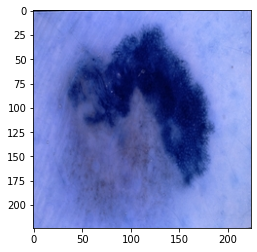

In [ ]:
img_test = x_test[100]
print(img_test.shape)
plt.imshow(img_test)
img_test = img_test.reshape(1,224, 224, 3)
predi=model.predict(img_test)

In [ ]:
print(predi)

[[2.1017144e-05 9.9997902e-01]]


In [ ]:
len(y_train_test)